# SpamDetector

## Preprocessing

In [1]:
#%run ExtractContent.py TR/ TRAIN/

In [301]:
%%python3
import nltk
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Error loading punkt: <urlopen error [Errno 8] nodename nor
[nltk_data]     servname provided, or not known>
[nltk_data] Downloading package stopwords to /Users/lminy/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [305]:
%%script bash
python3 FeaturesFromMail.py TR/ TRAIN/ >> /dev/null

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/bs4/__init__.py:282: UserWarning: "http://www.post-gazette.com/columnists/20020905brian5.asp" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup


In [306]:
# Get labels
import string
import csv
y = list() # y = labels
with open('spam-mail.tr.label','rb') as f :
    labels_reader = csv.reader(f, delimiter=',')
    count_row = 0

    for row in labels_reader:
        if count_row != 0 :
            y.append(row[1])
        count_row = count_row + 1
        
class_names = ['Spam', 'Ham']
#print y

In [296]:
with open('TRAIN/features', 'r') as f :
    features = json.loads(f.read())
    print features[3][:3]
    # text = Object + Body + Attachment if .txt + Attachment filenames + X-Mailer
    # nbrHops = # of server where the mail has been received (# of received in mail header)
    # nbrReceivers = total # of receiver in To, Cc and Bcc
    # validityDate = the date mail is valid only if not in the future
    features_name = ['text', 'nbrHops', 'nbrReceivers', 'validityDate']
print features[0][0]

[1, 1, 1]
one kind money maker tri free consant bombard call free money make system teas limit inform it said done blind side demand money credit card inform upfront slick way fact yes skeptic offer internet general hype probabl fortun main busi slow self employ life look someth fit lifestyl way assist pay bill without work death loos money propos tri someth new without upfront invest great none interest click link provid dont regret happi happi enough recommend system true word mean absolut upfront money join make money also get track result time effort instant updat daili especi like idea person control real time stay inform statist system quit simpli logic open fair other iv seen start get specif fact need serious consid right teas grand testimoni kid fact unlik program give no idea overal plan first fork money credit card worst yet join find late wast valuabl time tri figur system straightforward inform provid two thing realli must know what  how work  ultim deal maker 

In [307]:
text = features[0]
# Compute TF-IDF features
tfidf = TfidfVectorizer()#stop_words='english', strip_accents='ascii')
tfidf.fit(text) # tfidf remembers the term frequencies and vocabulary that was used to fit it.
X = tfidf.transform(text)
#print(type(X))

In [308]:
# Divise dataset
def divide_dataset(X, y) :
    from sklearn.model_selection import train_test_split
    X_train, X_test, y_train, y_test = train_test_split(X.toarray(), y, test_size=0.33, random_state=42)
    return (X_train, X_test, y_train, y_test)

X_train, X_test, y_train, y_test = divide_dataset(X, y)

## Machine Learning

### Tools

In [6]:
# Inspired from : http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
import numpy as np
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt
%matplotlib inline

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    #plt.figure()
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

Confusion matrix, without normalization


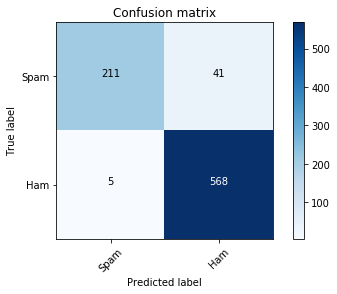

In [11]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cnf_matrix, classes=class_names, title='Confusion matrix')

In [ ]:
#k-NN, Naive Bayes, SVM, Perceptron

# Classification

In [309]:
from sklearn.model_selection import GridSearchCV
from sklearn import tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import GaussianNB


In [310]:
results = dict()

In [327]:
import time
import datetime
def train(classifier, name, param_grid=None) :
    start_time = time.time()
    if param_grid == None :
        classifier.fit(X_train, y_train)
        results[name] = dict(model=classifier)
    else :
        grid = GridSearchCV(classifier, param_grid, cv=10, scoring='accuracy', n_jobs=2) # Do a 10-fold cross validation
        grid.fit(X, y) # fit the grid with data
        results[name] = dict(grid=grid, model=classifier)
    #total_time = datetime.datetime.fromtimestamp(time.time() - start_time)
    total_time = datetime.timedelta(seconds=time.time() - start_time)
    print("Training time : " + str(total_time))#.strftime('%H:%M:%S'))

## k-NN classifier

In [313]:
name = "k-NN"
classifier = KNeighborsClassifier(weights='uniform')
k_range = list(range(1, 31)) # list of parameter values to test
param_grid = dict(n_neighbors=k_range)
train(classifier, name, param_grid)

Training time : 0:01:29.348193


## Decision tree

In [314]:
name = "Decision tree"
classifier = tree.DecisionTreeClassifier(criterion='entropy')
d_range = list(range(1, 31)) # list of parameter values to test
#s_range = list(range(2, 10))
param_grid = dict(max_depth=d_range)#, min_samples_split=s_range)
train(classifier, name, param_grid)

Training time : 0:01:16.971181


## Naive Bayes

In [328]:
name = "Naive Bayes - Gaussian"
classifier = GaussianNB()
train(classifier, name)

Training time : 0:00:02.622089


In [329]:
name = "Naive Bayes - Multinomial"
classifier = MultinomialNB()
train(classifier, name)

Training time : 0:00:00.277185


In [330]:
name = "Naive Bayes - Bernoulli"
classifier = BernoulliNB()
train(classifier, name)

Training time : 0:00:01.709258


## SVM - Support Vector Machine

In [145]:
name = "SVM"
classifier = svm.SVC()
C_range = np.logspace(-2, 10, 13)
print C_range
gamma_range = np.logspace(-9, 3, 13)
print gamma_range
param_grid = dict(gamma=gamma_range, C=C_range)
train(classifier, name, param_grid)

In [146]:
print(range(1, 100, 10))

[1, 11, 21, 31, 41, 51, 61, 71, 81, 91]


In [319]:
name = "SVM - Linear"
classifier = svm.LinearSVC()
C_range = range(170,230,5)
C_range = range(1,200,10)
param_grid = dict(C=C_range)
train(classifier, name, param_grid)

Training time : 0:01:12.919035


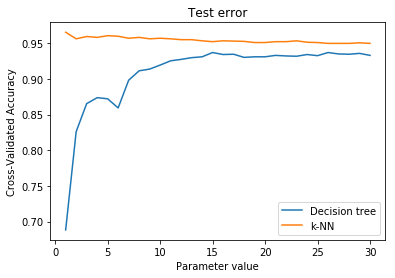

In [334]:
for clf_name, result in results.iteritems() :
    #plt.clf()
    #plt.figure()
    if 'grid' in result and (clf_name == 'k-NN' or clf_name == 'Decision tree'):
        grid = result['grid']
        grid_mean_scores = grid.cv_results_['mean_test_score']
        plt.plot(k_range, grid_mean_scores, label=clf_name)
        plt.title("Test error")
        #plt.title(clf_name)
        plt.legend()
        plt.xlabel('Parameter value')
        plt.ylabel('Cross-Validated Accuracy')
        #plt.show()
    else : # Model without param
        pass

In [336]:
from prettytable import PrettyTable
import operator
t = PrettyTable(['Model', 'Best score', 'Best params', 'FP', 'TN'])
for clf_name, result in results.iteritems() :
    model = result['model']
    if 'grid' in result :
        grid = result['grid']
        # Compute false positives and false negatives
        model.__init__(**grid.best_params_)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        cm = confusion_matrix(y_test, y_pred)
        fp = cm[1,0]
        tn = cm[0,1]
        
        t.add_row([clf_name, round(grid.best_score_, 4), grid.best_params_, fp, tn])
        #print(result.best_estimator_)
    else : # For non grid_search models
        #training_error = clf.score(X_train, y_train)
        test_error = model.score(X_test, y_test)
        
        # Compute false positives and false negatives
        y_pred = model.predict(X_test)
        cm = confusion_matrix(y_test, y_pred)
        fp = cm[1,0]
        tn = cm[0,1]
        t.add_row([clf_name, round(test_error, 4), None, fp, tn])
        
print t.get_string(sort_key=operator.itemgetter(2, 1), sortby="Best score", reversesort=True)

+---------------------------+------------+--------------------+----+-----+
|           Model           | Best score |    Best params     | FP |  TN |
+---------------------------+------------+--------------------+----+-----+
|        SVM - Linear       |   0.9792   |     {'C': 11}      | 5  |  19 |
|            k-NN           |   0.9652   | {'n_neighbors': 1} | 15 |  20 |
|       Decision tree       |   0.9368   | {'max_depth': 15}  | 33 |  43 |
|   Naive Bayes - Gaussian  |   0.9285   |        None        | 24 |  35 |
| Naive Bayes - Multinomial |   0.8739   |        None        | 0  | 104 |
|  Naive Bayes - Bernoulli  |   0.7636   |        None        | 14 | 181 |
+---------------------------+------------+--------------------+----+-----+


# Prediction

In [158]:
#%run ExtractContent.py TT/ TEST_pre/

The destination directory is newly created.


In [169]:
mails_kaggle = get_mails('TEST_pre', 'TEST')
# Compute TF-IDF features
X_kaggle = tfidf.transform(mails_kaggle)

In [170]:
# Train again the classifier on the whole datasets (X, y) including testing datasets
# with the best hyper parameters
#grid = results["Decision tree"]
#grid.predict()

model = svm.LinearSVC(C=180)
#best_max_depth = 7
#model = tree.DecisionTreeClassifier(criterion='entropy', max_depth=best_max_depth) # classifier = learning algorithm that will learn from the training dataset
model.fit(X, y)

# Now predict new mails from the TEST dataset (non-labeled)
y_kaggle = model.predict(X_kaggle)

In [171]:
# Store predicted labels
fd = open('spam-mail.tt.label', 'w')
fd.write('Id,Prediction')

for i in range(0, len(y_kaggle)):
    fd.write('\n%d,%s' % (i+1, y_kaggle[i]))

fd.close()